# First of all

In [ ]:
import ee

# Trigger the authentication flow.
# ee.Authenticate()

# Initialize the library.
ee.Initialize()

# Loading the Collection

## Landsat 8 Bands and Band Combinations

Landsat-8 (previously known as the Landsat Data Continuity Mission, LDCM), a joint NASA/USGS mission, was launched on 11 February 2013, with two instruments that are operated simultaneously, but independently  which are the Operational Land Imager (OLI) and Thermal Infrared Sensor (TIRS).

**The Operational Land Imager (OLI)** produces 9 spectral bands (Band 1 to 9) at 15, 30, and 60-meter resolution.  Those bands can be used to discriminate vegetation types, cultural features, biomass, vigor, etc.

**The Thermal Infrared Sensor (TIRS)** consists of 2 thermal bands with a spatial resolution of 100 meters. Those bands are for observing land surface temperature

As the successor to the earlier Landsat satellites, the intent was to provide data into the future that is sufficiently consistent with previous Landsat

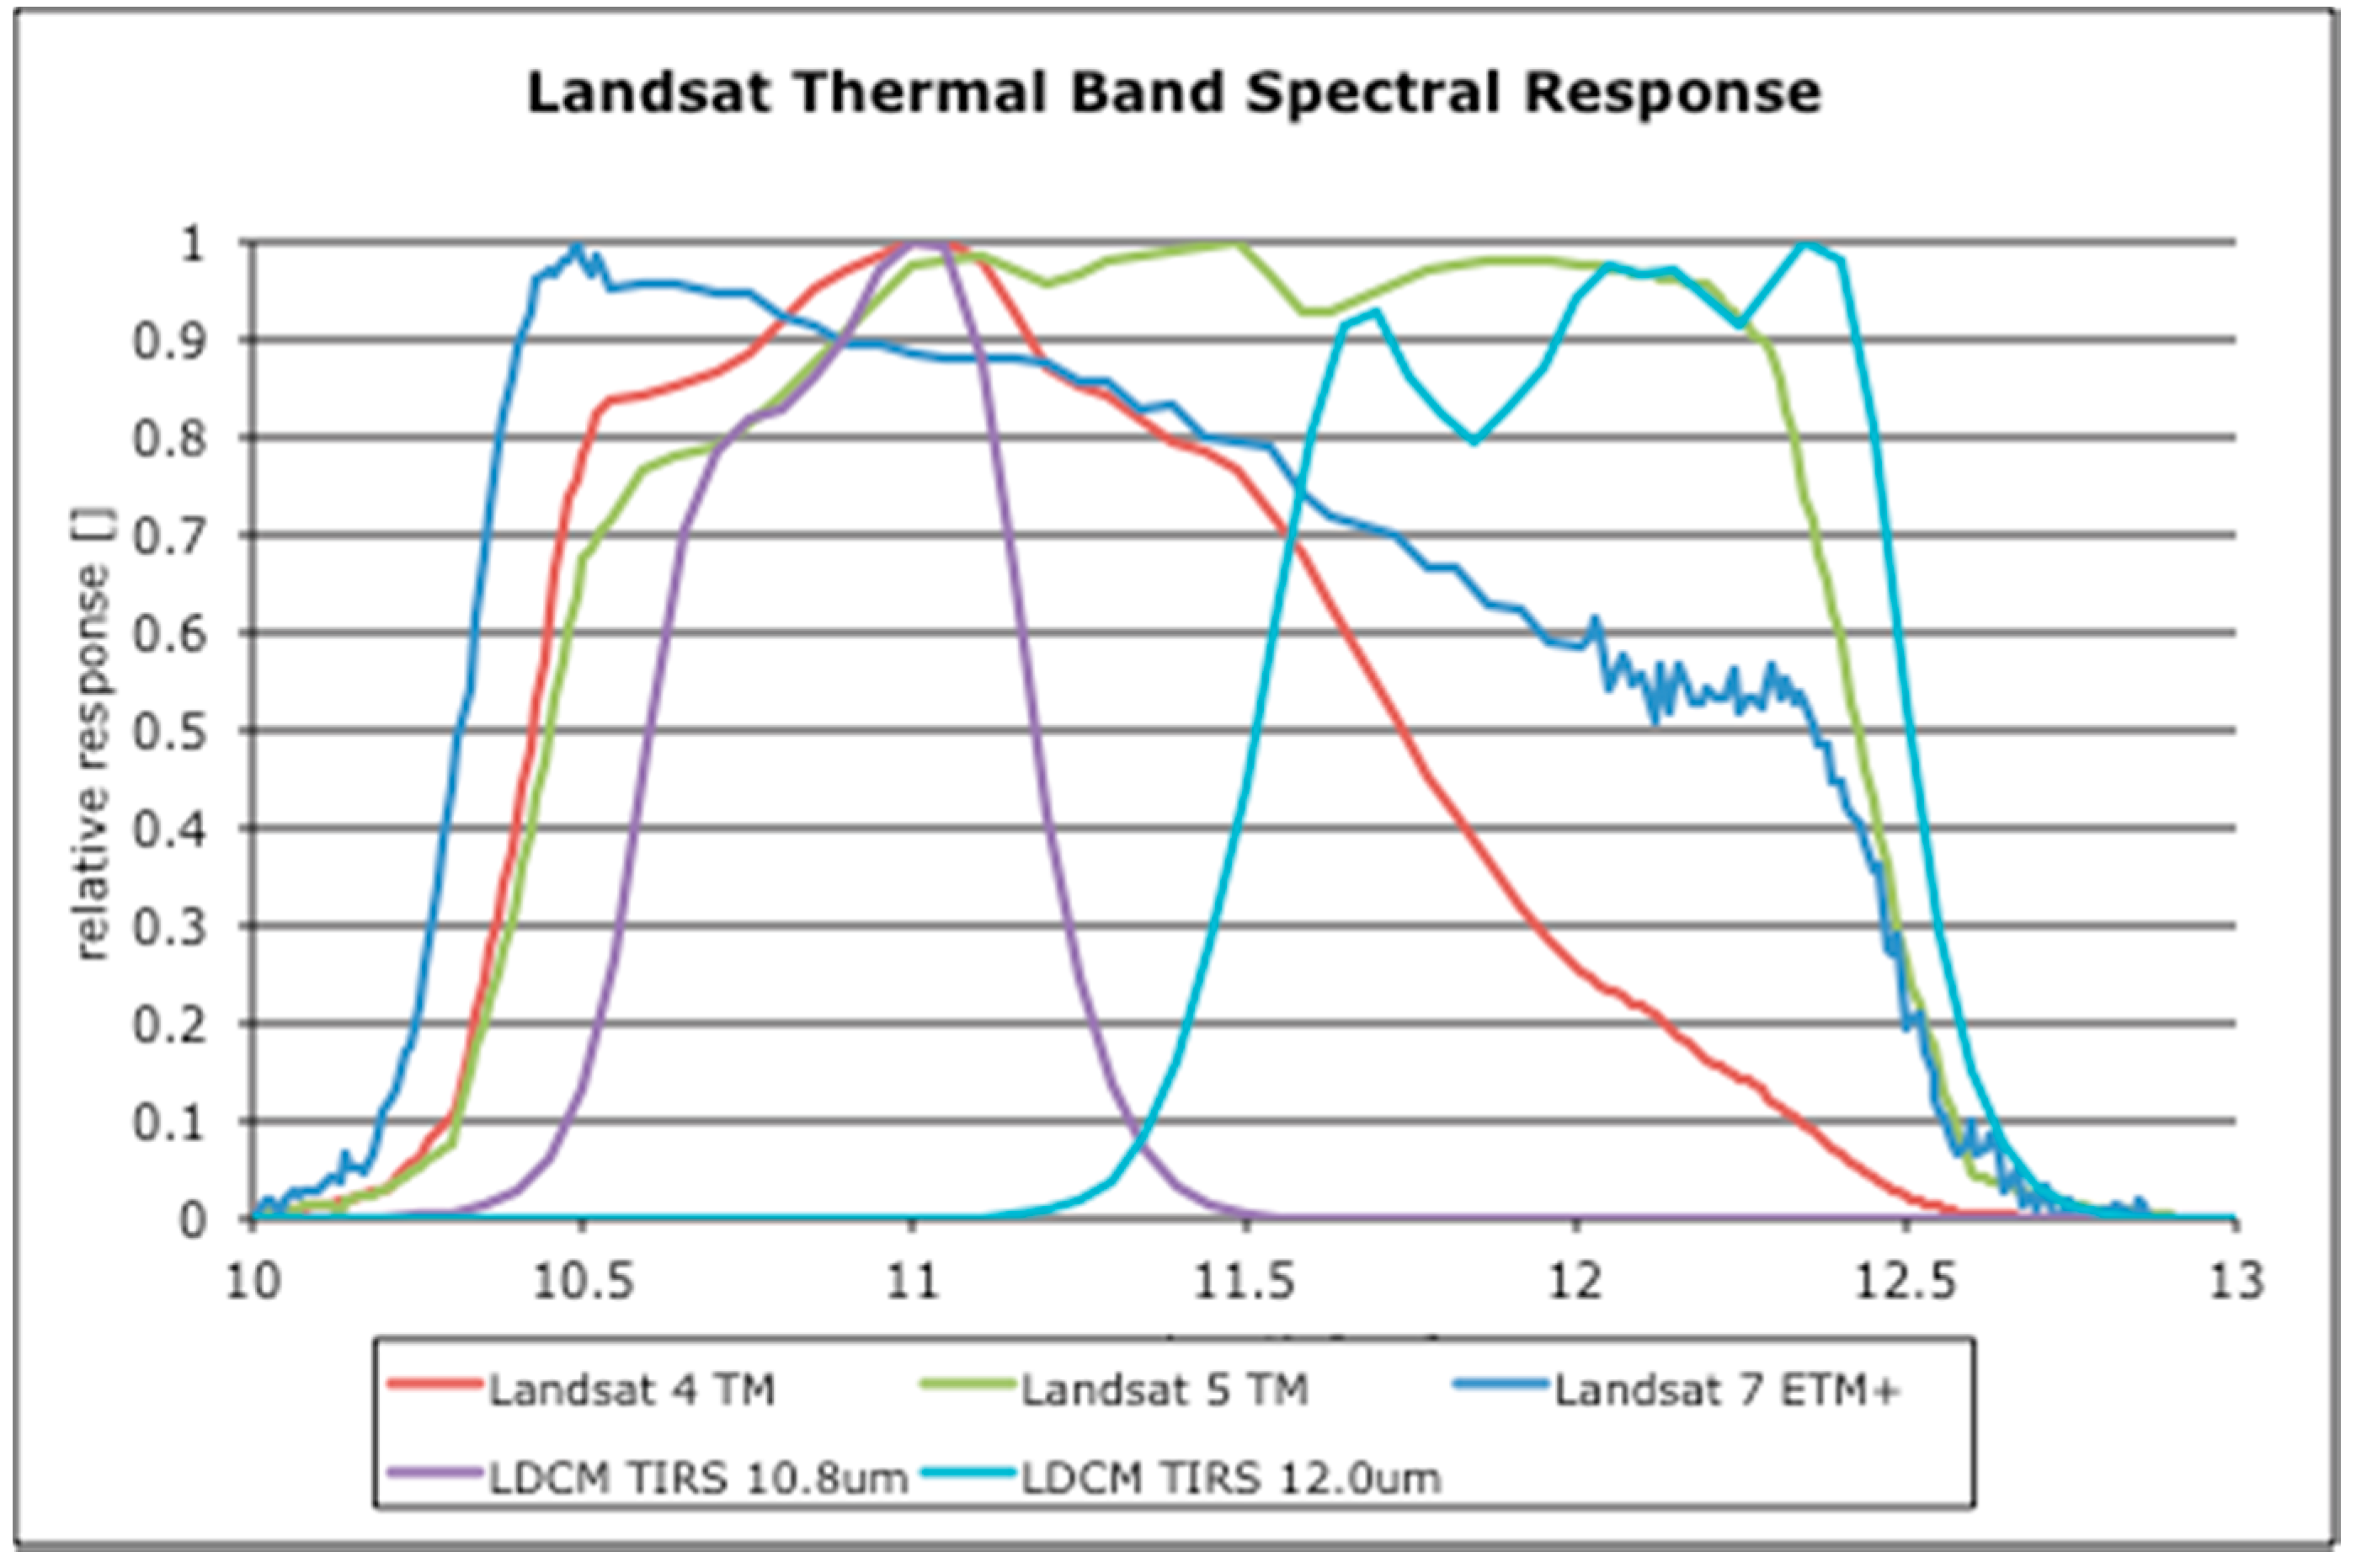

## Load Location

In [ ]:
import pandas as pd
df_itally = pd.read_csv('/content/it.csv')
df_itally.head()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Rome,41.8931,12.4828,Italy,IT,Lazio,primary,2872800,2872800
1,Milan,45.4669,9.1900,Italy,IT,Lombardy,admin,1366180,1366180
2,Naples,40.8333,14.2500,Italy,IT,Campania,admin,966144,966144
3,Turin,45.0667,7.7000,Italy,IT,Piedmont,admin,870952,870952
4,Palermo,38.1157,13.3613,Italy,IT,Sicilia,admin,668405,668405


In [ ]:
df_itally.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3373 entries, 0 to 3372
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   city               3373 non-null   object 
 1   lat                3373 non-null   float64
 2   lng                3373 non-null   float64
 3   country            3373 non-null   object 
 4   iso2               3373 non-null   object 
 5   admin_name         3373 non-null   object 
 6   capital            115 non-null    object 
 7   population         3373 non-null   int64  
 8   population_proper  3373 non-null   int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 237.3+ KB


In [ ]:
italy_df =df_itally.drop(columns=['country','iso2','admin_name','capital','admin_name','population','population_proper'],axis=1)
italy_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3373 entries, 0 to 3372
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    3373 non-null   object 
 1   lat     3373 non-null   float64
 2   lng     3373 non-null   float64
dtypes: float64(2), object(1)
memory usage: 79.2+ KB


In [ ]:
selectCity_df=italy_df[italy_df['city']=='Milan']
selectCity_df

,city,lat,lng
1,Milan,45.4669,9.19


In [ ]:
features=[]
for index, row in selectCity_df.iterrows():
    poi_geometry = ee.Geometry.Point([row['lat'], row['lng']])
#     print(poi_geometry)
#     construct the attributes (properties) for each point 
    poi_properties = dict(row)
#     construct feature combining geometry and properties
    poi_feature = ee.Feature(poi_geometry, poi_properties)
    features.append(poi_feature)

    # final Feature collection assembly
ee_fc = ee.FeatureCollection(features) 
ee_fc.getInfo()

{'type': 'FeatureCollection',
 'columns': {'city': 'String',
  'lat': 'Float',
  'lng': 'Float',
  'system:index': 'String'},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [45.4669, 9.19]},
   'id': '0',
   'properties': {'city': 'Milan', 'lat': 45.4669, 'lng': 9.19}}]}

In [ ]:
# city of Milan
AOI = ee.Geometry.Point(selectCity_df['lng'].values[0], selectCity_df['lat'].values[0])
#A test with a region near Portland, Oregon, USA
START_DATE = '2020-01-01'
END_DATE = '2020-12-31'
CLOUD_FILTER = 60
CLD_PRB_THRESH = 50
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50



# Mapping

In [ ]:
import folium
# Define a method for displaying Earth Engine image tiles to a folium map.
def add_ee_layer(self, ee_image_object, vis_params, name, show=True, opacity=1, min_zoom=0):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        show=show,
        opacity=opacity,
        min_zoom=min_zoom,
        overlay=True,
        control=True
        ).add_to(self)

# Add the Earth Engine layer method to folium.
folium.Map.add_ee_layer = add_ee_layer


In [ ]:
# Create a folium map object.
center = AOI.centroid(10).coordinates().reverse().getInfo()
m = folium.Map(location=center, zoom_start=12)
def Map_lst_composite(mcollection,namee):


  # Add layers to the folium map.
  m.add_ee_layer(mcollection,
                #Bands: allows the user to specify which bands to render as red, green, and blue.
                  {'bands': ['B4', 'B3', 'B2'],
                  #Min and max: sets the stretch range of the colors. The range is dependent on the data type
                  'min': 300, 'max': 3000, 'gamma': 1.1},
                  #Name of the layer on the map
                  namee)
  m.add_child(folium.LayerControl())


# Load data

Reming : Images collected are Raster. Raster is an image with a matrix of values reprensenting the values of some observed attribute.

Each matrix here cand be called band

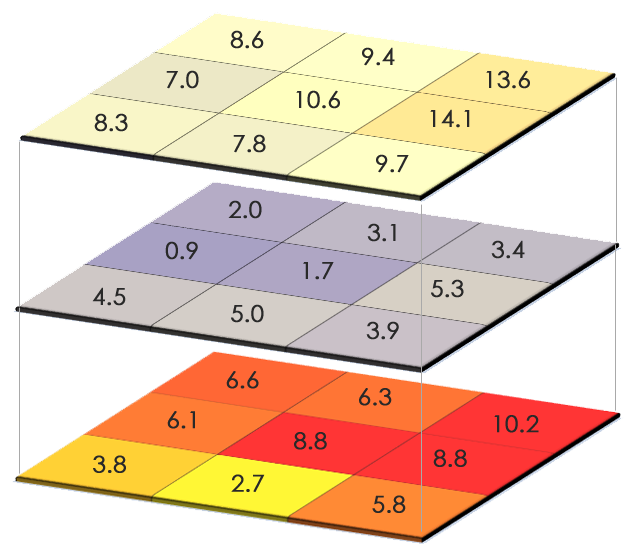

***Conceptual figures sourced from GISGeography***

`ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')` Load landsat 8  collection since 2013 for the entire globe thats why filtering process to our area of interest and time period is needed.

In [ ]:
# Load landsat 8 collection since 2013 for the entire globe
lst8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR');
# Filtering
lst8Filt = lst8.filterBounds(AOI) \
			   .filterDate(START_DATE,END_DATE)

Creating of composite band that means apply a `ee.Reducer.*` in order to obtain one value by location instead of time serie for each band

In other words `Reducers` are ways to aggregate data over time, space, bands, and other data structures. 

`median()` reducer method is one of the method that could be applied


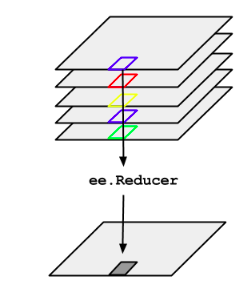

In [ ]:
composite_median = lst8Filt.median()
Map_lst_composite(composite_median,'LandSat8 F Date')


## adding a pre-filter for clouds when filtering our collection

In [ ]:
lst8FiltNoCloud = lst8.filterBounds(AOI)\
               .filterDate(START_DATE,END_DATE)\
               .filterMetadata('CLOUD_COVER','less_than',CLOUD_FILTER)

In [ ]:
composite_median_cloud = lst8FiltNoCloud.median()



For more robust cloud filtering, there is a band called `pixel_qa` “Quality Assessment (QA)” 

In [ ]:
def maskLst8srClouds(image) :
  #Bits 3 and 5 are cloud shadow and cloud, respectively.
  cloudShadowBitMask = (1 << 3);
  cloudsBitMask = (1 << 5);
  # Get the pixel QA band.
  qa = image.select('pixel_qa');
  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) and (qa.bitwiseAnd(cloudsBitMask).eq(0))
  return image.updateMask(mask)

lst8FiltNoCloudRobust = lst8.filterBounds(AOI)\
               .filterDate(START_DATE,END_DATE)\
               .filterMetadata('CLOUD_COVER','less_than',CLOUD_FILTER).map(maskLst8srClouds)
composite_median_cloud_robust = lst8FiltNoCloudRobust.median()

In [ ]:
m = folium.Map(location=center, zoom_start=12)

m.add_ee_layer(composite_median,
                #Bands: allows the user to specify which bands to render as red, green, and blue.
                  {'bands': ['B4', 'B3', 'B2'],
                  #Min and max: sets the stretch range of the colors. The range is dependent on the data type
                  'min': 300, 'max': 3000, 'gamma': 1.1},
                  #Name of the layer on the map
                  'Filter Date')
m.add_ee_layer(composite_median_cloud,
                #Bands: allows the user to specify which bands to render as red, green, and blue.
                  {'bands': ['B4', 'B3', 'B2'],
                  #Min and max: sets the stretch range of the colors. The range is dependent on the data type
                  'min': 300, 'max': 3000, 'gamma': 1.1},
                  #Name of the layer on the map
                  'Filter Date Cloud')
m.add_ee_layer(composite_median_cloud_robust,
                #Bands: allows the user to specify which bands to render as red, green, and blue.
                  {'bands': ['B4', 'B3', 'B2'],
                  #Min and max: sets the stretch range of the colors. The range is dependent on the data type
                  'min': 300, 'max': 3000, 'gamma': 1.1},
                  #Name of the layer on the map
                  'Filter Date Cloud Robust')
m.add_child(folium.LayerControl())
display(m)

# Merging lansat8 with Previous generation of Landsat

The interest opf this processing step is for instance if  we want obtain collection of data before 2013 or complete data missing due to the cloud. The Landsat 7 was launched in 1999 

The challenges are 

1.   bands name are different :
Whereas for Landsat 8 the red, green, and blue bands are B4, B3, and B2, respectively, for Landsat 7, these same bands are B3, B2, and B1, respectively.
2.   Frequencies are different because the sensors aboard each of the landsat satellites were designed to acquire data in different ranges of frequencies
3. Number of bands are different : Landsat 7 collection has 6 bands and the Landsat 8 has 12 bands



## LandSat 7

**NB**: since 2003, the sensor has acquired and delivered data with data gaps caused by the Scan Line Corrector (SLC) failure

In [ ]:
#get landsat 7 data
lst7 = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR')
#data filtering
composite7_median= lst7.filterBounds(AOI)\
               .filterDate(START_DATE,END_DATE).median()
composite7_median_cloud = lst7.filterBounds(AOI)\
               .filterDate(START_DATE,END_DATE)\
               .filterMetadata('CLOUD_COVER','less_than',CLOUD_FILTER).median()
lst7FiltNoCloudRobust = lst7.filterBounds(AOI)\
               .filterDate(START_DATE,END_DATE)\
               .filterMetadata('CLOUD_COVER','less_than',CLOUD_FILTER).map(maskLst8srClouds)
composite7_median_cloud_robust = lst7FiltNoCloudRobust.median()

In [ ]:
m = folium.Map(location=center, zoom_start=12)

m.add_ee_layer(composite7_median,
                #Bands: allows the user to specify which bands to render as red, green, and blue.
                  {'bands': ['B3', 'B2', 'B1'],
                  #Min and max: sets the stretch range of the colors. The range is dependent on the data type
                  'min': 300, 'max': 3000, 'gamma': 1.1},
                  #Name of the layer on the map
                  'Filter7 Date')
m.add_ee_layer(composite7_median_cloud,
                #Bands: allows the user to specify which bands to render as red, green, and blue.
                  {'bands': ['B3', 'B2', 'B1'],
                  #Min and max: sets the stretch range of the colors. The range is dependent on the data type
                  'min': 300, 'max': 3000, 'gamma': 1.1},
                  #Name of the layer on the map
                  'Filter7 Date Cloud')
m.add_ee_layer(composite7_median_cloud_robust,
                #Bands: allows the user to specify which bands to render as red, green, and blue.
                  {'bands': ['B3', 'B2', 'B1'],
                  #Min and max: sets the stretch range of the colors. The range is dependent on the data type
                  'min': 300, 'max': 3000, 'gamma': 1.1},
                  #Name of the layer on the map
                  'Filter7 Date Cloud Robust')
m.add_child(folium.LayerControl())
display(m)

Combining both sensors into one composite

In [ ]:
#Landsat 8 bands 
composite_median_cloud_robust.bandNames().getInfo()

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B10',
 'B11',
 'sr_aerosol',
 'pixel_qa',
 'radsat_qa']

In [ ]:
#Landsat 7 bands
composite7_median_cloud_robust.bandNames().getInfo()

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'sr_atmos_opacity',
 'sr_cloud_qa',
 'pixel_qa',
 'radsat_qa']

In [ ]:
# Renaming Landsat 7 band designations
def rename(image):
  return image.select(
    ['B1', 'B2', 'B3', 'B4', 'B5', 'B7'],
    ['B2', 'B3', 'B4', 'B5', 'B6', 'B7'])
lst7FiltMaskedRenamed = lst7FiltNoCloudRobust.map(rename)

Only renaming is not enough because they do not have the same number of bands

In [ ]:
lst78 = lst7FiltMaskedRenamed.merge(lst8FiltNoCloudRobust)

It is better to select the matching band first

In [ ]:
lst78_best = lst7FiltMaskedRenamed.merge(lst8FiltNoCloudRobust.select('B2','B3','B4','B5','B6','B7'))
composite_lst78_median=lst78_best.median()

In [ ]:
m = folium.Map(location=center, zoom_start=12)


m.add_ee_layer(composite_median_cloud_robust,
                #Bands: allows the user to specify which bands to render as red, green, and blue.
                  {'bands': ['B4', 'B3', 'B2'],
                  #Min and max: sets the stretch range of the colors. The range is dependent on the data type
                  'min': 300, 'max': 3000, 'gamma': 1.1},
                  #Name of the layer on the map
                  'Filter Date Cloud Robust')
m.add_ee_layer(composite7_median_cloud_robust,
                #Bands: allows the user to specify which bands to render as red, green, and blue.
                  {'bands': ['B3', 'B2', 'B1'],
                  #Min and max: sets the stretch range of the colors. The range is dependent on the data type
                  'min': 300, 'max': 3000, 'gamma': 1.1},
                  #Name of the layer on the map
                  'Filter7 Date Cloud Robust')
m.add_ee_layer(composite_lst78_median,
                #Bands: allows the user to specify which bands to render as red, green, and blue.
                  {'bands': ['B4', 'B3', 'B2'],
                  #Min and max: sets the stretch range of the colors. The range is dependent on the data type
                  'min': 300, 'max': 3000, 'gamma': 1.1},
                  #Name of the layer on the map
                  'Lst 7 and 8 clean')
m.add_child(folium.LayerControl())
display(m)